The notebook implements the idea described in the [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [92]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *

In [2]:
path = untar_data(URLs.PETS)

In [3]:
path.ls()

[WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/images')]

In [4]:
bs=64

In [12]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
(path/'annotations').ls()

[WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/list.txt'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/README'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/test.txt'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/trimaps'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/annotations/xmls')]

In [7]:
src = ImageList.from_folder(path/"images").split_by_rand_pct(0.2).label_from_re(r'([^/]+)_\d+.jpg$')

In [24]:
def get_data(src, tfms, size, bs, padding_mode='reflection'):
    return src.transform(tfms, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)

In [25]:
tfms[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [33]:
data = get_data(src, tfms, 352, 32)

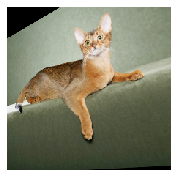

In [31]:
x, y = data.train_ds[0]
x.show()

In [32]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\sepolt\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
german_shorthaired,wheaten_terrier,boxer,Maine_Coon,Siamese
Path: C:\Users\sepolt\.fastai\data\oxford-iiit-pet\images;

Test: None

In [34]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

In [37]:
m = learn.model.eval()

Category leonberger

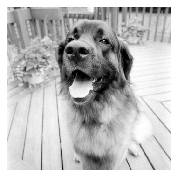

In [236]:
idx = 12
x, y = data.valid_ds[idx]
x.show()
y

In [237]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [238]:
res = m(xb)

In [239]:
(res.argmax().cpu().numpy())

array(25, dtype=int64)

In [240]:
data.classes[16]

'boxer'

In [241]:
res

tensor([[-0.4885, -1.0344, -0.1656, -1.0209, -0.4455, -0.6697, -0.5553, -0.5481,
         -0.1446,  0.4599, -0.5942,  0.1741, -0.3553, -0.2958, -0.3766, -0.2509,
         -1.3137, -0.2310,  0.0446,  0.2463,  0.5450,  2.3408, -1.3331, -0.5050,
          1.2383,  6.5272, -0.5249,  1.8030, -0.2295,  0.0253,  1.4379, -0.0140,
         -1.6296,  0.7659, -0.6706,  0.0973, -0.4095]], device='cuda:0',
       grad_fn=<CudnnBatchNormBackward>)

In [242]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [243]:
hook_a, hook_g = hooked_backward()

In [244]:
acts = hook_a.stored[0].cpu()
avg_acts = acts.mean(0)

In [245]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

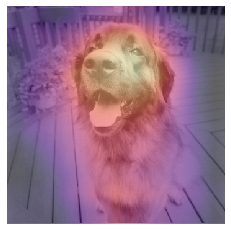

In [246]:
show_heatmap(avg_acts)

In [247]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [248]:
mult = (acts*grad_chan[...,None,None])

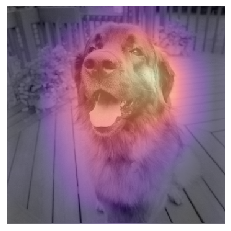

In [249]:
show_heatmap(mult.mean(0))

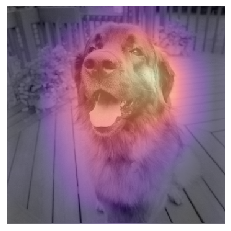

In [250]:
show_heatmap(mult.sum(0))

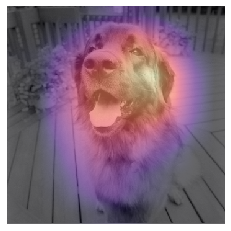

In [251]:
sum_rel = F.relu(mult.sum(0))
show_heatmap(sum_rel)